# Klasyfikacja asteroid jako zagrażające Ziemii

In [2]:
import os
from dotenv import load_dotenv
from pymongo import MongoClient
import pandas as pd

load_dotenv()

def get_mongo_uri():
    uri = os.getenv("MONGO_URI")
    if not uri:
        raise ValueError("MONGO_URI environment variable not set")
    return uri

client = MongoClient(get_mongo_uri())
db = client["NEO-Cluster"]
collection = db["asteroids"]

mongoData = collection.find({}, projection=['_id', 'name', 'absolute_magnitude_h', 'estimated_diameter', 'is_potentially_hazardous_asteroid', 'close_approach_data', 'orbital_data.orbit_determination_date'])
df_mongo = pd.DataFrame(list(mongoData))

client.close()

Czyszczenie danych, aby nie zawierały pustych list `close_approach_data`. 

In [11]:
import seaborn as sns
from matplotlib import pyplot as plt

df_cleaned = df_mongo[df_mongo['close_approach_data'].apply(lambda x: len(x) != 0)].dropna()
df_cleaned

,_id,name,absolute_magnitude_h,estimated_diameter,is_potentially_hazardous_asteroid,close_approach_data,orbital_data
0,662eb325d56dd93e65b342fc,433 Eros (A898 PA),10.41,{'kilometers': {'estimated_diameter_min': 22.0...,False,"[{'close_approach_date': '1900-12-27', 'close_...",{'orbit_determination_date': '2021-05-24 17:55...
1,662eb325d56dd93e65b342fd,719 Albert (A911 TB),15.59,{'kilometers': {'estimated_diameter_min': 2.02...,False,"[{'close_approach_date': '1909-08-21', 'close_...",{'orbit_determination_date': '2024-02-16 05:25...
2,662eb325d56dd93e65b342fe,887 Alinda (A918 AA),13.88,{'kilometers': {'estimated_diameter_min': 4.45...,False,"[{'close_approach_date': '1910-01-04', 'close_...",{'orbit_determination_date': '2024-01-21 05:18...
3,662eb325d56dd93e65b342ff,1036 Ganymed (A924 UB),9.26,{'kilometers': {'estimated_diameter_min': 37.3...,False,"[{'close_approach_date': '1910-02-25', 'close_...",{'orbit_determination_date': '2024-04-25 05:47...
4,662eb325d56dd93e65b34300,1221 Amor (1932 EA1),17.38,{'kilometers': {'estimated_diameter_min': 0.88...,False,"[{'close_approach_date': '1900-03-08', 'close_...",{'orbit_determination_date': '2023-10-12 20:33...
...,...,...,...,...,...,...,...
37186,666f4b4ced5abd8b3c8a0586,163902 (2003 SW222),17.21,{'kilometers': {'estimated_diameter_min': 0.96...,False,"[{'close_approach_date': '1913-12-27', 'close_...",{'orbit_determination_date': '2024-06-12 06:19...
37187,666f4b4ced5abd8b3c8a0587,523637 (2010 LT108),19.52,{'kilometers': {'estimated_diameter_min': 0.33...,False,"[{'close_approach_date': '1905-03-20', 'close_...",{'orbit_determination_date': '2024-06-05 10:14...
37188,666f4b4fed5abd8b3c8a0588,523661 (2012 LF11),20.81,{'kilometers': {'estimated_diameter_min': 0.18...,False,"[{'close_approach_date': '1900-09-24', 'close_...",{'orbit_determination_date': '2024-06-07 06:20...
37189,666f4b51ed5abd8b3c8a0589,523796 (2016 LE51),20.03,{'kilometers': {'estimated_diameter_min': 0.26...,False,"[{'close_approach_date': '1905-07-20', 'close_...",{'orbit_determination_date': '2024-06-14 06:20...


Przetwarzanie danych: wyciąganie średniej wartości średnicy asteroidy w kilometrach.

In [12]:


mean_diameters_km = [ (diam['kilometers']['estimated_diameter_min'] + diam['kilometers']['estimated_diameter_max']) / 2.0 for diam in df_cleaned['estimated_diameter']]

# Test
mean_diameters_km[0] == (df_cleaned['estimated_diameter'][0]['kilometers']['estimated_diameter_min'] + df_cleaned['estimated_diameter'][0]['kilometers']['estimated_diameter_max']) / 2.0

True

Wyszukiwanie starszej, ale najbliższej `close_approach_date` do `orbit_determination_date`. Jest to konieczne gdyż `orbit_determination_date` najprawdopodobniej odnosi się do tego konkretnego `close_approach_data`.

In [13]:
import numpy as np

closest_approach_objs = []
for close_approach_array, orbital_data in zip(df_cleaned['close_approach_data'], df_cleaned['orbital_data']):
    close_approach_dates = [item['close_approach_date'] for item in close_approach_array]
    determination_date = orbital_data['orbit_determination_date']
    closest_approach_date_position = np.searchsorted(close_approach_dates, determination_date, side='left')
    closest_approach_objs.append(close_approach_array[closest_approach_date_position-1])

km_per_second = [ data['relative_velocity']['kilometers_per_second'] for data in closest_approach_objs ]
miss_distance_km = [ data['miss_distance']['kilometers'] for data in closest_approach_objs ]

In [14]:
asteroid_df_column_names = ['name', 'absolute_magnitude', 'mean_diameter_km', 'relative_velocity_km_s', 'miss_distance_km', 'is_hazardous']
asteroid_df_column_values = [df_cleaned['name'], df_cleaned['absolute_magnitude_h'], mean_diameters_km, pd.to_numeric(km_per_second), pd.to_numeric(miss_distance_km), df_cleaned['is_potentially_hazardous_asteroid']]

asteroid_df = pd.DataFrame(data=dict(zip(asteroid_df_column_names, asteroid_df_column_values)))
asteroid_df.info()
asteroid_df

<class 'pandas.core.frame.DataFrame'>
Index: 36413 entries, 0 to 37190
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   name                    36413 non-null  object 
 1   absolute_magnitude      36413 non-null  float64
 2   mean_diameter_km        36413 non-null  float64
 3   relative_velocity_km_s  36413 non-null  float64
 4   miss_distance_km        36413 non-null  float64
 5   is_hazardous            36413 non-null  bool   
dtypes: bool(1), float64(4), object(1)
memory usage: 2.7+ MB


,name,absolute_magnitude,mean_diameter_km,relative_velocity_km_s,miss_distance_km,is_hazardous
0,433 Eros (A898 PA),10.41,35.607593,6.044918,3.120592e+07,False
1,719 Albert (A911 TB),15.59,3.277499,3.724128,2.223920e+08,False
2,887 Alinda (A918 AA),13.88,7.203484,11.662202,5.055901e+07,False
3,1036 Ganymed (A924 UB),9.26,60.470369,14.304702,5.372123e+07,False
4,1221 Amor (1932 EA1),17.38,1.437284,15.600596,5.505391e+07,False
...,...,...,...,...,...,...
37186,163902 (2003 SW222),17.21,1.554328,8.477422,4.285204e+07,False
37187,523637 (2010 LT108),19.52,0.536467,20.040668,2.568349e+07,False
37188,523661 (2012 LF11),20.81,0.296171,20.963655,3.537093e+07,False
37189,523796 (2016 LE51),20.03,0.424173,21.622387,4.561614e+07,False


In [15]:
asteroid_df.corr(numeric_only=True)

,absolute_magnitude,mean_diameter_km,relative_velocity_km_s,miss_distance_km,is_hazardous
absolute_magnitude,1.000000,-0.506376,-0.313832,-0.414415,-0.307193
mean_diameter_km,-0.506376,1.000000,0.160111,0.199949,0.120910
relative_velocity_km_s,-0.313832,0.160111,1.000000,-0.001967,0.203725
miss_distance_km,-0.414415,0.199949,-0.001967,1.000000,0.081395
is_hazardous,-0.307193,0.120910,0.203725,0.081395,1.000000


## Eksploracja danych

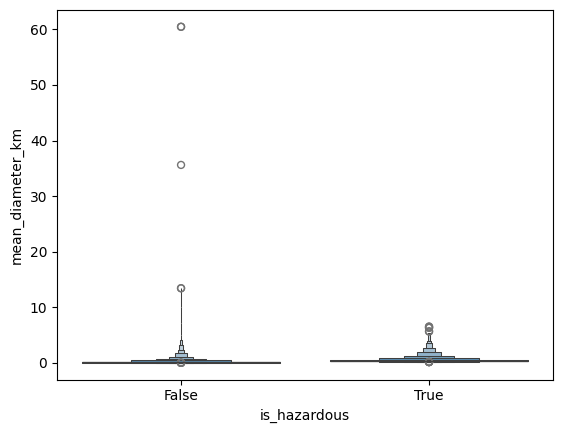

In [16]:
sns.boxenplot(x='is_hazardous', y='mean_diameter_km',data=asteroid_df)
plt.show()

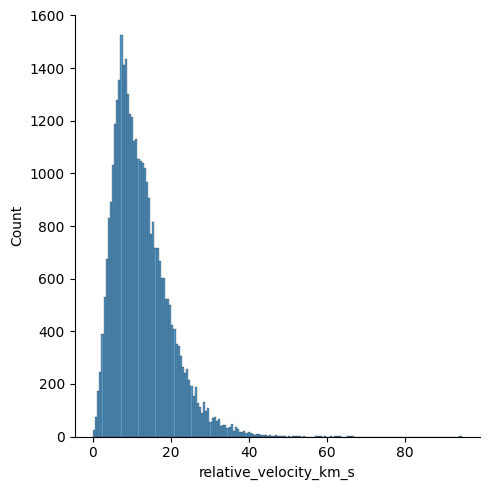

In [17]:
sns.displot(asteroid_df['relative_velocity_km_s'])

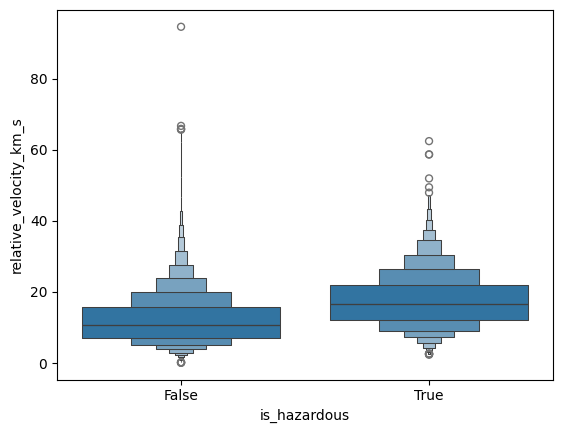

In [18]:
sns.boxenplot(x='is_hazardous', y='relative_velocity_km_s',data=asteroid_df)
plt.show()

Obiekty zagrażające Ziemii średnio mają większą prędkość i są większe.

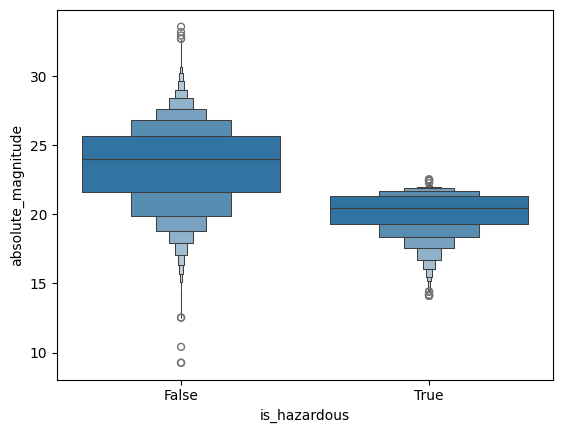

In [19]:
sns.boxenplot(x='is_hazardous', y='absolute_magnitude',data=asteroid_df)
plt.show()

Obiekty zagrażające Ziemii na ogół mają wyższą moc promieniowania (jasność).

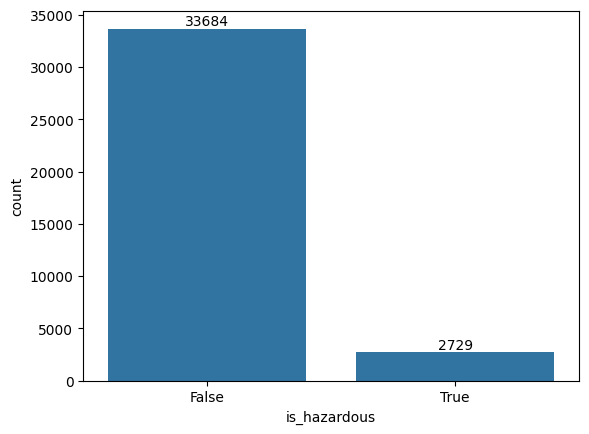

In [20]:
hazardous_plot = sns.countplot(x='is_hazardous', data=asteroid_df)
hazardous_plot.bar_label(hazardous_plot.containers[0])
plt.show()

Zbiór jest nienajlepiej zbalansowany pod względem `is_hazardous`, który to będzie celem uczenia. Powodem niezbalansowania może być mniejsza ogólna moc promieniowania wykryta we wcześniejszej analizie.

## Modelowanie

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

x_train, x_test, y_train, y_test = train_test_split(asteroid_df.drop(columns=['name', 'is_hazardous']), asteroid_df['is_hazardous'], test_size=0.2)

x_train.shape,y_train.shape,x_test.shape,y_test.shape

((29130, 4), (29130,), (7283, 4), (7283,))

In [36]:
def model_validation(y_test, y_predicted):
    print('Classification report\n', classification_report(y_test, y_predicted))
    conf_matrix = confusion_matrix(y_test, y_predicted)
    ConfusionMatrixDisplay(conf_matrix).plot()
    plt.show()

[LightGBM] [Info] Number of positive: 2171, number of negative: 26959
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 29130, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074528 -> initscore=-2.519129
[LightGBM] [Info] Start training from score -2.519129
Classification report
               precision    recall  f1-score   support

       False       0.99      0.82      0.90      6725
        True       0.29      0.89      0.44       558

    accuracy                           0.83      7283
   macro avg       0.64      0.85      0.67      7283
weighted avg       0.94      0.83      0.86      7283



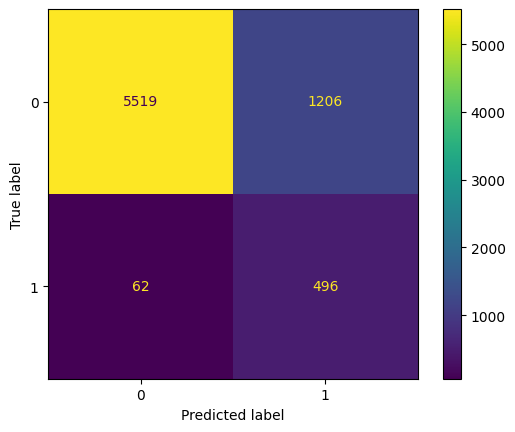

In [46]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(is_unbalance=True)
lgbm_model = lgbm.fit(x_train, y_train)
y_pred = lgbm_model.predict(x_test)

model_validation(y_test, y_pred)

LGBM korzysta z Gradient Boosted Trees.
Parametr `is_unbalance=True` dla klasyfikacji binarnej informuje algorytm, że zbiór danych uczących jest niezbalansowany, a konkretnie ilość danych dla konkretnych klas. Powoduje to wyliczenie odpowiednich wag dla dwóch klasy: asteroid zagrających Ziemii oraz asteroid nie zagrażających Ziemii.
Model był optymalizowany tak, aby mieć jak najlepszą czułość, czyli najwyższe prawdopodobieństwo, iż asteroida zagrażająca Ziemii zostanie rzeczywiście sklasyfikowana jako zagrażająca Ziemi. Minimalizacja przypadków `False Negative`. Powoduje to ogólny spadek trafności, ale jest to nieuniknione ze względu na niezbalansowaną ilość danych dla klas.
Lepiej jest mieć więcej fałszywych alarmów niż koniec świata...